In [1]:
# !pip install arcgis

In [2]:
"""Plague Classification Model with ArcGIS Data - Oversampling Implementation"""

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from sklearn.utils import class_weight

In [3]:
# Parámetros de la red
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 1000
LEARNING_RATE = 1e-4


In [4]:
images_dir = '../arcgis-survey-images'

In [5]:
# Cargar dataset de imágenes
train_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    shuffle=True
)

validation_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names

Found 3289 files belonging to 5 classes.
Using 2632 files for training.
Found 3289 files belonging to 5 classes.
Using 657 files for validation.


In [6]:
# Obtener las etiquetas de entrenamiento
all_labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
unique_classes, counts = np.unique(all_labels, return_counts=True)
class_counts = dict(zip(unique_classes, counts))
max_count = max(class_counts.values())
print(f"Tamaño de la clase mayoritaria: {max_count}")

# Desagrupar el dataset antes de filtrar
train_ds_unbatched = train_ds.unbatch()

# Crear un diccionario para almacenar los datasets por clase
datasets_per_class = {}
for class_index in unique_classes:
    filtered_ds = train_ds_unbatched.filter(lambda x, y: y == class_index)
    datasets_per_class[class_index] = filtered_ds

# Sobremuestrear las clases minoritarias
balanced_datasets = []
for class_index, dataset in datasets_per_class.items():
    class_count = class_counts[class_index]
    num_repeats = max_count // class_count
    remainder = max_count % class_count

    repeated_ds = dataset.repeat(num_repeats)

    if remainder > 0:
        extra_ds = dataset.shuffle(BUFFER_SIZE).repeat().take(remainder)
        repeated_ds = repeated_ds.concatenate(extra_ds)

    balanced_datasets.append(repeated_ds)

# Combinar los datasets balanceados
balanced_train_ds = balanced_datasets[0]
for ds in balanced_datasets[1:]:
    balanced_train_ds = balanced_train_ds.concatenate(ds)

# Aplicar data augmentation al dataset balanceado
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

augmented_balanced_train_ds = balanced_train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Aplicar batching y prefetching
augmented_balanced_train_ds = augmented_balanced_train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Verificar que las clases están balanceadas
balanced_class_counts = np.zeros(len(class_names))
for images, labels in augmented_balanced_train_ds:
    for label in labels:
        balanced_class_counts[label.numpy()] += 1

print("\nDistribución de clases en el dataset balanceado:")
for i, count in enumerate(balanced_class_counts):
    print(f"Clase: {class_names[i]}, Número de ejemplos: {int(count)}")



Tamaño de la clase mayoritaria: 799

Distribución de clases en el dataset balanceado:
Clase: Chinche salivosa, Número de ejemplos: 799
Clase: Clororis, Número de ejemplos: 799
Clase: Hoja sana, Número de ejemplos: 799
Clase: Roya naranja, Número de ejemplos: 799
Clase: Roya purpura, Número de ejemplos: 799


In [7]:
# Definir el modelo
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [8]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenamiento del modelo
history = model.fit(
    augmented_balanced_train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
    125/Unknown 122s 753ms/step - accuracy: 0.2527 - loss: 5.6060

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 793ms/step - accuracy: 0.2528 - loss: 5.6055 - val_accuracy: 0.4429 - val_loss: 4.5122 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 790ms/step - accuracy: 0.3968 - loss: 4.8473 - val_accuracy: 0.4962 - val_loss: 4.3768 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 785ms/step - accuracy: 0.4690 - loss: 4.5823 - val_accuracy: 0.5221 - val_loss: 4.2467 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 767ms/step - accuracy: 0.5127 - loss: 4.3542 - val_accuracy: 0.6088 - val_loss: 4.0432 - learning_rate: 1.0000e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 760ms/step - accuracy: 0.5390 - loss: 4.1874 - val_accuracy: 0.6256 - val_loss: 4.0080 - learning_rate: 1.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 761ms/step - accuracy: 0.5595 - loss: 4.1201 - val_accuracy: 0.6332 - val_loss: 3.8769 - learning_rate: 1.0000e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 765ms/step -

In [9]:
# Guardar el modelo en formato .keras
model.save('Oversampling.keras')

In [11]:
# Evaluación en el conjunto de test
test_ds = validation_ds.shard(num_shards=2, index=1)
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7634 - loss: 1.3386
Resultados de evaluación en test set:
accuracy: 0.8031
loss: 1.3360


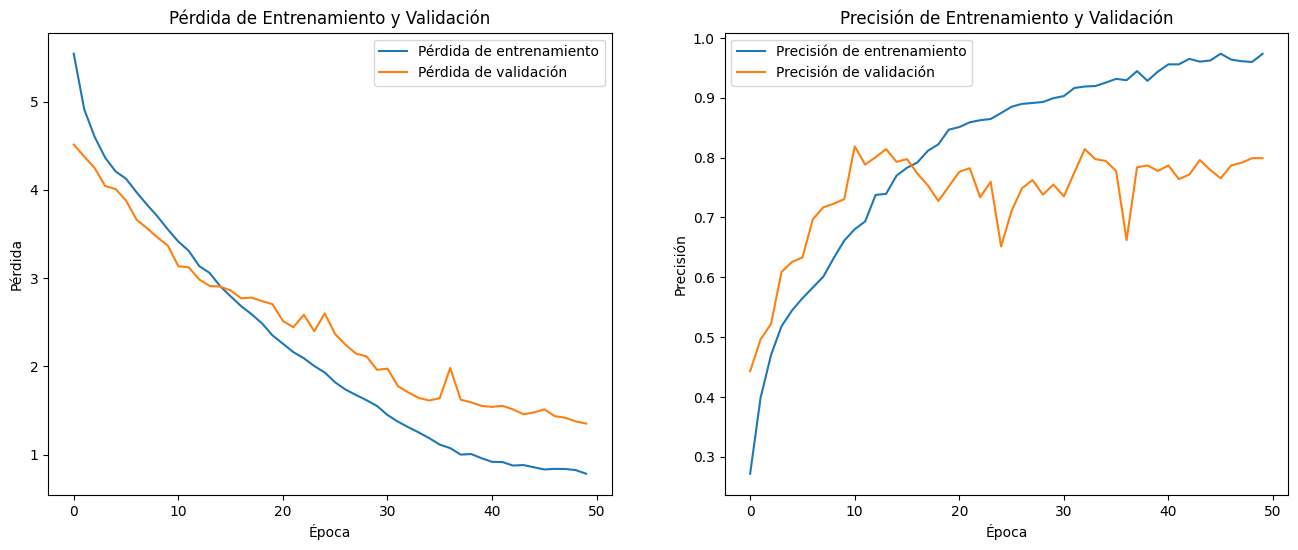

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step


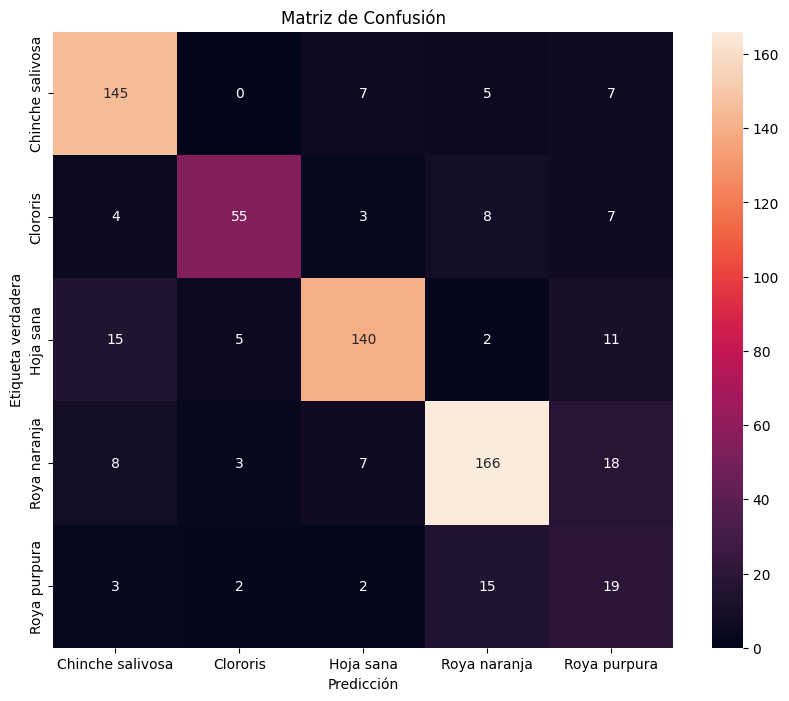

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.83      0.88      0.86       164
        Clororis       0.85      0.71      0.77        77
       Hoja sana       0.88      0.81      0.84       173
    Roya naranja       0.85      0.82      0.83       202
    Roya purpura       0.31      0.46      0.37        41

        accuracy                           0.80       657
       macro avg       0.74      0.74      0.74       657
    weighted avg       0.82      0.80      0.81       657



In [10]:
# Evaluación y visualización
metrics = history.history
plt.figure(figsize=(16, 6))

# Gráfica de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Pérdida de entrenamiento')
plt.plot(history.epoch, metrics['val_loss'], label='Pérdida de validación')
plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')

# Gráfica de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.epoch, metrics['val_accuracy'], label='Precisión de validación')
plt.legend()
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.show()

# Matriz de confusión y reporte de clasificación
test_ds = validation_ds
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))